In [11]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pydicom
import nibabel as nib
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from IPython.display import display, clear_output

import os
import os.path

import scipy.ndimage
import scipy.signal


In [12]:
def plot_images(img_stack, *, labels=None, figdim=5, colormap=plt.cm.gray, show=True, **imshowkwarg):
    """
    Funzione di utilità per mostrare una grigli di immagini, impostando la lista delle legende
    e, opzionalmente, la colormap che di default è impostata a livelli di grigio
    """    
    nimag = len(img_stack)

    # creiamo il layout
    nrows = 1 if nimag <= 3 else 2 if nimag <= 6 else 3 if nimag <=12 else 4 if nimag <= 16 else 5
    ncols = nimag if nrows == 1 else 2 if nimag == 4 else 3 if nimag <=9 else 4 if nimag <= 16 else 5

    # generiamo la figura con un canvas ce riserva 5x5 pollici a immagine
    # e i riferimenti alle singole immagini
    fig, axs = plt.subplots(nrows,ncols,squeeze=False,figsize=(figdim*ncols, figdim*nrows))
    
    img = 0 # contatore delle immagini

    for r in range(nrows):
        for c in range(ncols):
            # eliminiamo lo stile del grafico
            axs[r, c].tick_params(axis='both',\
                    which='both',\
                    bottom=False,top=False,right=False,left=False,\
                    labelbottom=False,labelleft=False)
            plt.gca().spines['top'].set_visible(False)
            plt.gca().spines['bottom'].set_visible(False)
            plt.gca().spines['left'].set_visible(False)
            plt.gca().spines['right'].set_visible(False)

            # se ci troviamo nella posizione di una
            # immagine allora la mostriamo
            if r*ncols + c < nimag:
                if labels != None:
                    axs[r, c].set_title(labels[img])
            
                axs[r, c].imshow(img_stack[img], cmap=colormap, **imshowkwarg)

                img += 1 # immagine successiva
    
    if show == True:
        plt.show()
    
    return axs


In [64]:
def load_dcm_volume(directory):
    """
    Funzione che carica un volume di dati DICOM da una cartella
    assumendo che questa contenga solamente un insieme di file .dcm
    """

    # leggiamo la lista dei file nella cartella
    files = os.listdir(directory)
    files.sort()
    
    # leggiamo il primo file per ottenere le dimensioni e il tipo della singola slice
    file = pydicom.dcmread(f'{directory}/{files[0]}')
    
    # creiamo il volume
    volume = np.full((len(files),file.pixel_array.shape[0],file.pixel_array.shape[1]),\
                    1,dtype=file.pixel_array.dtype)

    # carichiamo la prima slice, già letta, e successivamente le altre 
    volume[0,:,:] = file.pixel_array

    for i in range(1,len(files)):
        volume[i,:,:] = pydicom.dcmread(f'{directory}/{files[i]}').pixel_array
    
    vol = np.copy(volume)

    if file.SeriesDescription != '' and file.SeriesDescription.find('Sag') != -1:
        vol=np.reshape(vol,(volume.shape[1],volume.shape[2],volume.shape[0]))

        for i in range(volume[:,0,:].shape[1]):
            vol[i,:,:] = volume[:,i,:].T
    
    if file.SeriesDescription != '' and file.SeriesDescription.find('Cor') != -1:
        vol=np.reshape(vol,(volume.shape[1],volume.shape[0],volume.shape[2]))

        for i in range(volume[:,0,:].shape[0]):
            vol[i,:,:] = volume[:,i,:]
    
    return vol

def window(image, lower_threshold, upper_threshold):
    """
    Funzione che calcola la finestratura della dinamica di input
    per mapparla in [0 - 255]
    """
    
    # Saturiamo le soglie se sono fuori range rispetto all'immagine di ingresso
    if lower_threshold < np.min(image):
        lower_threshold = np.min(image)

    if upper_threshold > np.max(image):
        upper_threshold = np.max(image)
        
    dynamics = upper_threshold - lower_threshold

    # Creiamo la nuova immagine riempita di 1
    new_image = np.full((image.shape[0], image.shape[1]), 0, dtype='int')
    
    new_image[image <= lower_threshold] = 0
    new_image[image >= upper_threshold] = 255

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):

            # Applichiamo la trasformazione puntualmente
            if image[i, j] > lower_threshold and image[i, j] < upper_threshold:
                new_image[i, j] = int(255*(image[i, j] - lower_threshold)/dynamics)

    return new_image

In [14]:
def mini_pacs_viewer(directory):
    """
    Funzione di visualizzazione dei tra piani di un volume dicom caricato da una cartella
    che raccoglie una serie
    """

    # Carichiamo il volume DICOM
    dcm_volume = load_dcm_volume(directory)

    # creiamo gli slider per scorrere sui diversi piani di proiezione
    axial = widgets.IntSlider(min=0,max=dcm_volume.shape[0]-1,\
        value=dcm_volume.shape[0]//2,description='Ax',orientation='vertical')
    sagittal = widgets.IntSlider(min=0,max=dcm_volume.shape[2]-1,\
        value=dcm_volume.shape[2]//2,description='Sag',orientation='vertical')
    coronal = widgets.IntSlider(min=0,max=dcm_volume.shape[1]-1,\
        value=dcm_volume.shape[1]//2,description='Cor',orientation='vertical')

    # creiamo gli slider per modificare la finestratura della gamma dinamica
    top = np.max(dcm_volume)
    bottom = np.min(dcm_volume)

    lower = widgets.IntSlider(min=bottom,max=top,\
        value=bottom,description='Minimo',orientation='horizontal')
    upper = widgets.IntSlider(min=bottom,max=top,\
        value=top,description='Massimo',orientation='horizontal')


    # gestore degli eventi
    def draw_slices(a,s,c,l,u):

        # modifica del contrasto
        ax = window(dcm_volume[a,:,:],l,u)
        sag = window(dcm_volume[:,:,s],l,u)
        cor = window(dcm_volume[:,c,:],l,u)

        # display delle tre slice
        axes = plot_images([ax,sag,cor],\
        labels=['Piano Assiale','Piano Sagittale','Piano Coronale'],show=False)

        # display della traccia del piano assiale
        axes[0, 1].plot([0,dcm_volume[:,:,0].shape[1]-1],[a, a],'r-')
        axes[0, 2].plot([0,dcm_volume[:,0,:].shape[1]-1],[a, a],'r-')

        # display della traccia del piano sagittale
        axes[0, 0].plot([s, s],[0,dcm_volume[0,:,:].shape[0]-1],'g-')
        axes[0, 2].plot([s, s],[0,dcm_volume[:,0,:].shape[0]-1],'g-')

        # display della traccia del piano coronale
        axes[0, 1].plot([c, c],[0,dcm_volume[:,:,0].shape[0]-1],'b-')
        axes[0, 0].plot([0,dcm_volume[0,:,:].shape[1]-1],[c, c],'b-')
        
        plt.show()

    # Creazione del widget
    w = interactive(draw_slices,a=axial,s=sagittal,c=coronal,l=lower,u=upper)
    w.layout.flex_flow='row wrap'

    display(w)

    return dcm_volume

#mini_pacs_viewer('Data/Sag_FLAIR+FATSAT_CUBE_3')
#mini_pacs_viewer('Data/Ax_T2_FRFSE_8')
volume = mini_pacs_viewer('Data/series-00000')

interactive(children=(IntSlider(value=180, description='Ax', max=360, orientation='vertical'), IntSlider(value…

In [75]:
lung = {'level': -700, 'width': 1000}
soft = {'level': 50, 'width': 400}
bone = {'level': 400, 'width': 1800}
liver = {'level': 30, 'width': 150}

In [71]:
info = pydicom.dcmread('Data/series-00000/image-00107.dcm')
(intercept, slope) = (float(info.RescaleIntercept), float(info.RescaleSlope))
print(intercept, slope)
print(np.min(volume[22,:,:]), np.max(volume[22,:,:]))

-1000.0 1.0
0 2221


In [65]:
def compute_window(dicom_image, win, slope, intercept):
    """

    Args:
        dicom_data (FileDataSet | DicomDir): dato DICOM
        win (dict): la finestra di visualizzazione del tessuto richiesto in HU
        slope (int): la pendenza della legge di trasformazione dei pixel in HU
        intercept (int): l'intercetta della legge di trasformazione dei pixel in HU

    Returns:
        numpy array: immagine trasformata in HU, finestrata e riscalata in 0, 255
    """

    lower = win['level'] - win['width']//2
    upper = win['level'] + win['width']//2
    
    x = dicom_image*slope + intercept

    return window(x, lower, upper)
    

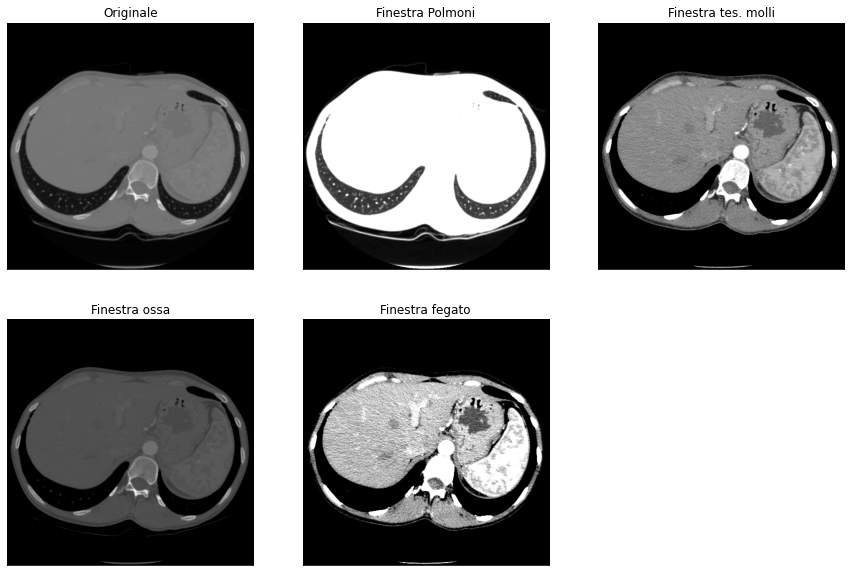

In [78]:
lung_slice = compute_window(volume[0,:,:], lung, slope, intercept)
soft_slice = compute_window(volume[0,:,:], soft, slope, intercept)
bone_slice = compute_window(volume[0,:,:], bone, slope, intercept)
liver_slice = compute_window(volume[0,:,:], liver, slope, intercept)

axes = plot_images([volume[0,:,:], lung_slice, soft_slice, bone_slice, liver_slice],\
    labels=['Originale', 'Finestra Polmoni', 'Finestra tes. molli', 'Finestra ossa', 'Finestra fegato'])